In [1]:
"""
This test explains how to use kenkenpa based on LangGraph's "Parallel node fan-out and fan-in".
Some parts of the test code are borrowed from the code at the following URL.
https://langchain-ai.github.io/langgraph/how-tos/branching/
"""


'\nThis test explains how to use kenkenpa based on LangGraph\'s "Parallel node fan-out and fan-in".\nSome parts of the test code are borrowed from the code at the following URL.\nhttps://langchain-ai.github.io/langgraph/how-tos/branching/\n'

In [2]:
import operator
from typing import Any

from kenkenpa.builder import StateGraphBuilder

# State is not defined. It is defined within graph_settings.
#class State(TypedDict):
#    The operator.add reducer fn makes this append-only
#    aggregate: Annotated[list, operator.add]
#    which: str

# Since the conditional edge that refers to the state is defined within graph_settings,
# this is also not defined.
#def route_bc_or_cd(state: State) -> Sequence[str]:
    #if state["which"] == "cd":
    #    return ["c", "d"]
    #return ["b", "c"]

In [3]:
# We will define a class that returns a ReturnNodeValue.
class ReturnNodeValue:
    def __init__(self, factory_parameter,flow_parameter):
        self._value = factory_parameter['node_secret']
    def __call__(self, state ) -> Any:
        print(f"Adding {self._value} to {state['aggregate']}")
        return {"aggregate": [self._value]}

In [4]:
# We will describe the settings of a compilable StateGraph in dictionary
graph_settings = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"Parallel-node",
        "state" : [
            {
                "field_name": "aggregate",
                "type": "list",
                "reducer":"add"
            },
            {
                "field_name": "which",
                "type": "str",
            },
        ],
    },
    "flows": [
        { # node a
            "graph_type":"node",
            "flow_parameter": {
                "name":"a",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm A"},
        },
        { # normal_edge START-> a
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"a"
            },
        },
        { # node b
            "graph_type":"node",
            "flow_parameter": {
                "name":"b",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm B"},
        },
        { # node c
            "graph_type":"node",
            "flow_parameter": {
                "name":"c",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm C"},
        },
        { # node d
            "graph_type":"node",
            "flow_parameter": {
                "name":"d",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm D"},
        },
        { # node e
            "graph_type":"node",
            "flow_parameter": {
                "name":"e",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm E"},
        },
        { # conditional edge a -> b,c or c,d
            "graph_type":"configurable_conditional_edge",
            "flow_parameter":{
                "start_key":"a",
                "conditions":[
                    {
                        "expression": {
                            "eq": [{"type": "state_value", "name": "which"}, "cd"],
                        },
                        "result": ["c","d"]
                    },
                    {"default": ["b","c"]}
                ]
            },
        },
        { # normal_edge b,c,d -> e
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":["b","c","d"],
                "end_key":"e"
            },
        },
        { # normal_edge e -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"e",
                "end_key":"END"
            },
        },
    ]
}

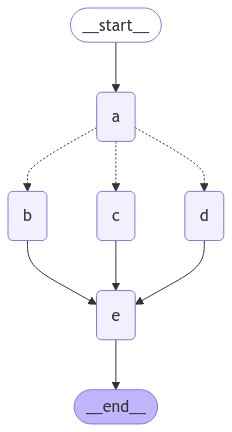

graph.invoke({"aggregate": [],"which":"bc"}, {"configurable": {"thread_id": "foo"}})
Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm E to ["I'm A", "I'm B", "I'm C"]
graph.invoke({"aggregate": [],"which":"cd"}, {"configurable": {"thread_id": "foo"}})
Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A"]
Adding I'm E to ["I'm A", "I'm C", "I'm D"]


{'aggregate': ["I'm A", "I'm C", "I'm D", "I'm E"], 'which': 'cd'}

In [5]:
# Generate the StateGraphBuilder from graph_settings.
stategraph_builder = StateGraphBuilder(graph_settings)

# The term "list" is reserved as a basic type. (*1)
#stategraph_builder.add_type("list",list)

# Register the reducer to be used in the StateGraphBuilder.
stategraph_builder.add_reducer("add",operator.add)

# Register the node factory with the stategraph_builder.
stategraph_builder.add_node_factory("gen_return_node_value",ReturnNodeValue)

# The gen_stategraph method generates a compilable StateGraph.
stategraph = stategraph_builder.gen_stategraph()

# From here on, we will write the code following the general usage of LangGraph.
graph = stategraph.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

print('graph.invoke({"aggregate": [],"which":"bc"}, {"configurable": {"thread_id": "foo"}})')
graph.invoke({"aggregate": [],"which":"bc"}, {"configurable": {"thread_id": "foo"}})

print('graph.invoke({"aggregate": [],"which":"cd"}, {"configurable": {"thread_id": "foo"}})')
graph.invoke({"aggregate": [],"which":"cd"}, {"configurable": {"thread_id": "foo"}})

# In StateGraphBuilder, the following types are pre-registered as basic types.
# "int":int,
# "float":float,
# "complex":complex,
# "str":str,
# "list":list,
# "tuple":tuple,
# "dict":dict,
# "set":set,
# "frozenset":frozenset,
# "bool":bool,